# Compare SSH from ROMS output and reanalysis


Compare: 
- roms area averaged sea level height above geoid
- sea level height above geoid along Dutch coast

Data:
- GLORYS12V2 downloaded from https://resources.marine.copernicus.eu/product-detail/GLOBAL_MULTIYEAR_PHY_001_030/INFORMATION
- GLORYS2V3 downloaded from Dewi workstation: /net/pc200008/nobackup/users/bars/GLORYS2V3
- ROMS output Tim downloaded from http://doi.org/10.4121/uuid:d9656541-ff40-45d0-8859-ac644b155dfb
- altimetry downloaded from https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION

For Tim's run with 1/8° resolution and  + GLORYS12v1

Dewi's runs with 1/4° and 1/8° resolution + GLORYS2V3

ROMS domain: 36°N to 62°N and -20°W to 10°E

In [53]:
# Import necessary packages

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import linregress

## SSH averaged over the ROMS domain

In [54]:
# Import GLORYS12V1 reanalysis data
glorys12v1 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Glorys12v1/SSH/glorys12v1_annual.nc')


# Make extent of the Glorys12v1 data similar to ROMS
glorys12v1 = glorys12v1.where((glorys12v1.latitude > 36) & (glorys12v1.latitude < 62) & (glorys12v1.longitude > -20) & (glorys12v1.longitude < 10), drop = True)


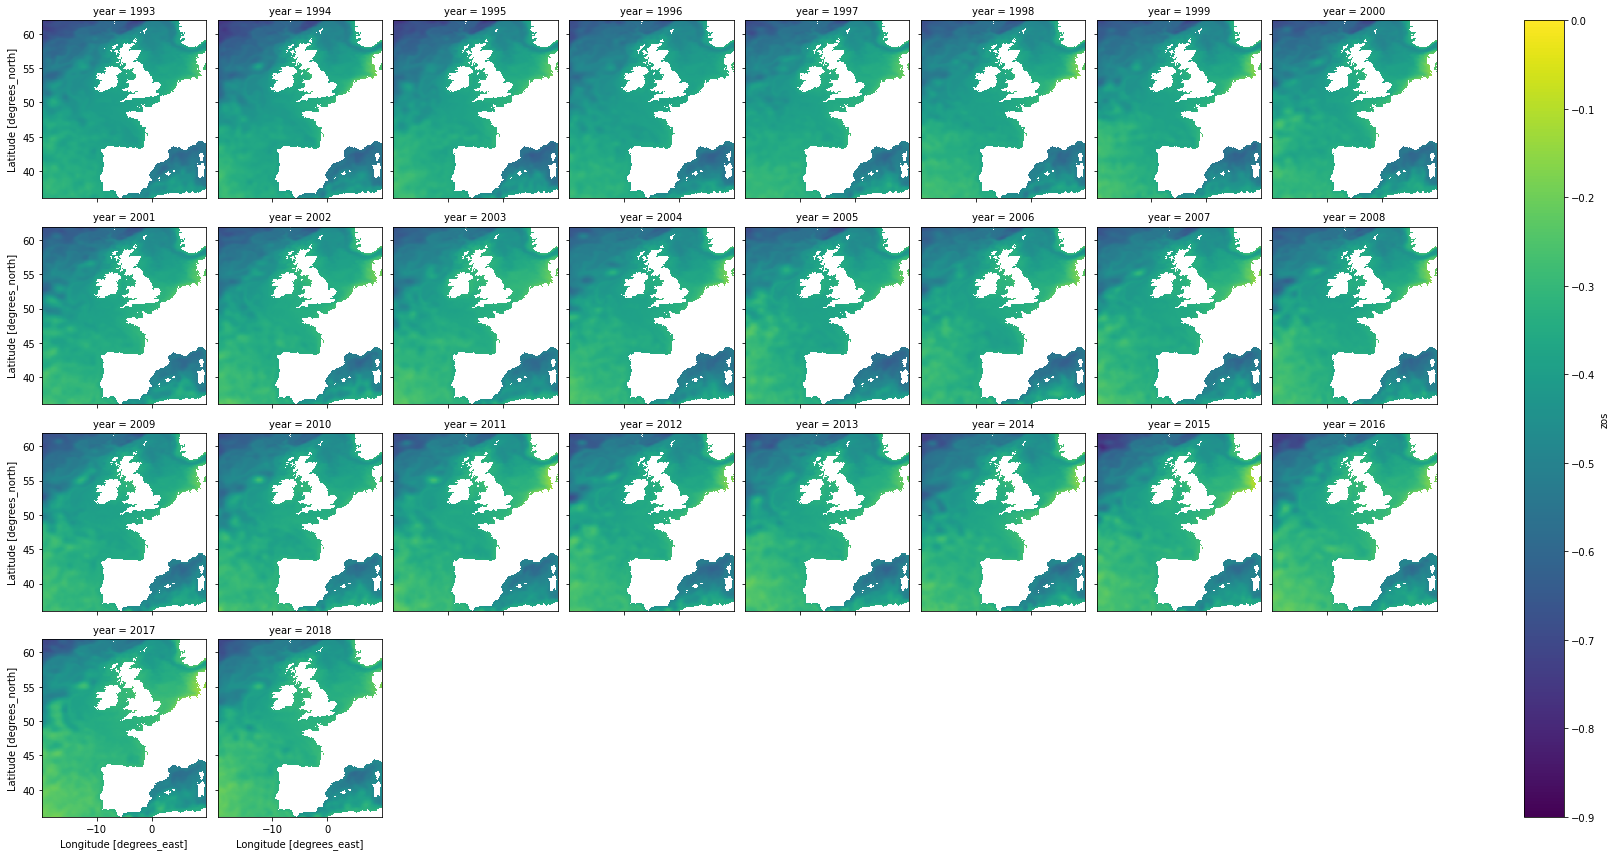

In [55]:
glorys12v1.zos.plot(col = 'year', col_wrap = 8, vmin = -0.9, vmax = 0) # Sea level [m]

In [56]:
# Import ROMS output from tim
roms_output_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Tim/ROMS_output_tim.nc')


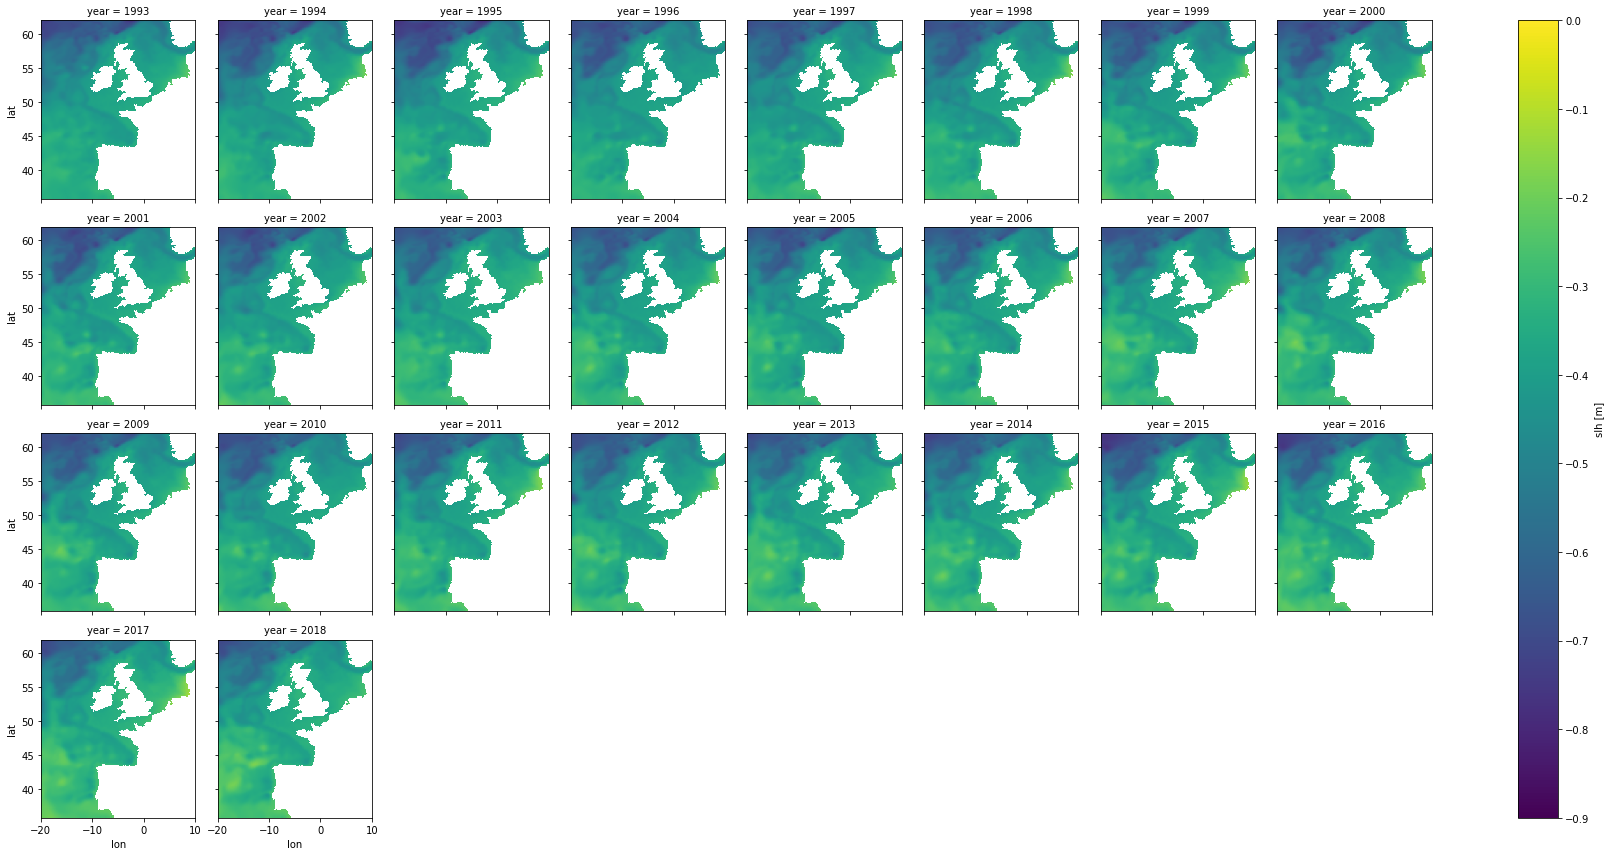

In [57]:
roms_output_tim.slh.plot(col = 'year', col_wrap = 8, vmin = -0.9, vmax = 0) # Sea level [m]

In [58]:
# Import altimetry data
cmems_altimetry = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/*.nc', parallel = True)

# Obtain annual averages
cmems_altimetry = cmems_altimetry.groupby('time.year').mean()

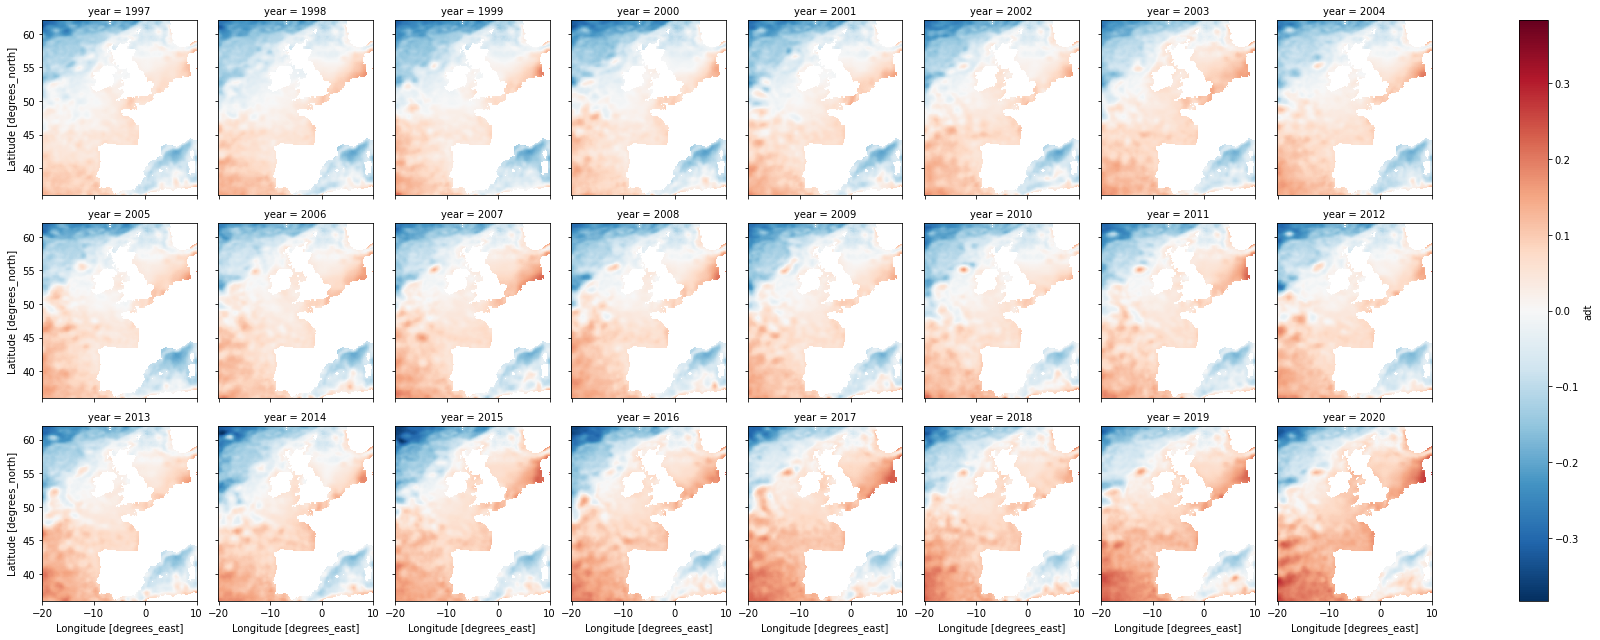

In [60]:
cmems_altimetry.adt.plot(col = 'year', col_wrap = 8) # Sea level [m]

In [61]:
# Import AVISO altimetry data
aviso_altimetry1 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/AVISO/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_1640275119401.nc')
aviso_altimetry2 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/AVISO/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_1640276798465.nc')

Sybrens data is helaas enkel sea level height above mean sea level

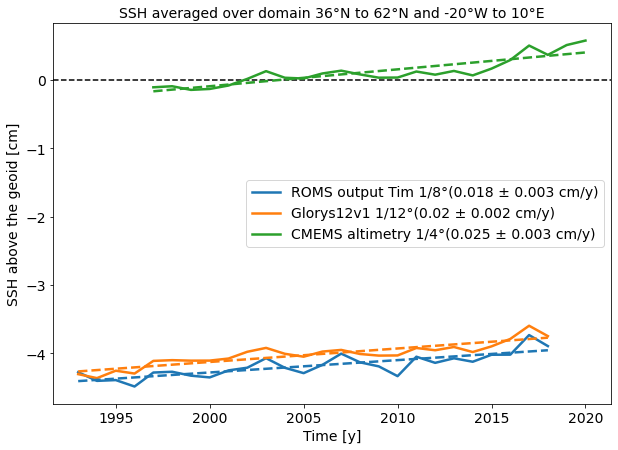

In [62]:
plt.figure(figsize = (10,7))

glorys_res = linregress(glorys12v1.year, glorys12v1.zos.mean('longitude').mean('latitude')*10)
glorys_trend = linregress(glorys12v1.year, glorys12v1.zos.mean('longitude').mean('latitude')*10).slope
glorys_se = linregress(glorys12v1.year, glorys12v1.zos.mean('longitude').mean('latitude')*10).stderr

roms_res = linregress(roms_output_tim.year, roms_output_tim.slh.mean('lat').mean('lon')*10)
roms_trend = linregress(roms_output_tim.year, roms_output_tim.slh.mean('lat').mean('lon')*10).slope
roms_se = linregress(roms_output_tim.year, roms_output_tim.slh.mean('lat').mean('lon')*10).stderr

cmems_res = linregress(cmems_altimetry.year, cmems_altimetry.adt.mean('longitude').mean('latitude')*10)
cmems_trend = linregress(cmems_altimetry.year, cmems_altimetry.adt.mean('longitude').mean('latitude')*10).slope
cmems_se = linregress(cmems_altimetry.year, cmems_altimetry.adt.mean('longitude').mean('latitude')*10).stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_tim.year, roms_output_tim.slh.mean('lat').mean('lon')*10, linewidth=2.5, label = f'ROMS output Tim 1/8°({round(roms_trend, 3)} ± {round(roms_se, 3)} cm/y)')
plt.plot(glorys12v1.year, glorys12v1.zos.mean('longitude').mean('latitude')*10, linewidth=2.5, label = f'Glorys12v1 1/12°({round(glorys_trend, 3)} ± {round(glorys_se, 3)} cm/y)')
plt.plot(cmems_altimetry.year, cmems_altimetry.adt.mean('longitude').mean('latitude')*10, linewidth=2.5, label = f'CMEMS altimetry 1/4°({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_tim.year, roms_res.intercept + roms_res.slope*roms_output_tim.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(glorys12v1.year, glorys_res.intercept + glorys_res.slope*glorys12v1.year, 'tab:orange', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_res.slope*cmems_altimetry.year, 'tab:green', linestyle = '--', linewidth = 2.5)



plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('SSH averaged over domain 36°N to 62°N and -20°W to 10°E', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_area_averaged_ssh_glorys12_timoutput8')

In [63]:
# Obtain anomalies
glorys_anom = glorys12v1.zos.mean('longitude').mean('latitude') - glorys12v1.where(glorys12v1.year >= 1997, drop = True).mean('longitude').zos.mean('latitude').mean('year')
roms_tim_anom = roms_output_tim.slh.mean('lat').mean('lon') - roms_output_tim.where(roms_output_tim.year >= 1997, drop = True).slh.mean('lat').mean('lon').mean('year')
cmems_anom = cmems_altimetry.adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude').mean('year')

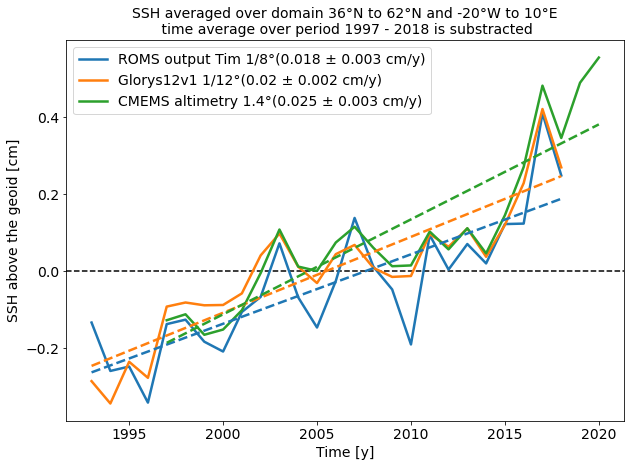

In [79]:
plt.figure(figsize = (10,7))


glorys_res = linregress(glorys12v1.year, glorys_anom*10)
glorys_trend = linregress(glorys12v1.year, glorys_anom*10).slope
glorys_se = linregress(glorys12v1.year, glorys_anom*10).stderr

roms_res = linregress(roms_output_tim.year, roms_tim_anom*10)
roms_trend = linregress(roms_output_tim.year, roms_tim_anom*10).slope
roms_se = linregress(roms_output_tim.year, roms_tim_anom*10).stderr

cmems_res = linregress(cmems_altimetry.year, cmems_anom*10)
cmems_trend = linregress(cmems_altimetry.year, cmems_anom*10).slope
cmems_se = linregress(cmems_altimetry.year, cmems_anom*10).stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_tim.year, roms_tim_anom*10, linewidth=2.5, label = f'ROMS output Tim 1/8°({round(roms_trend, 3)} ± {round(roms_se, 3)} cm/y)')
plt.plot(glorys12v1.year, glorys_anom*10, linewidth=2.5, label = f'Glorys12v1 1/12°({round(glorys_trend, 3)} ± {round(glorys_se, 3)} cm/y)')
plt.plot(cmems_altimetry.year, cmems_anom*10, linewidth=2.5, label = f'CMEMS altimetry 1.4°({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_tim.year, roms_res.intercept + roms_res.slope*roms_output_tim.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(glorys12v1.year, glorys_res.intercept + glorys_res.slope*glorys12v1.year, 'tab:orange', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_res.slope*cmems_altimetry.year, 'tab:green', linestyle = '--', linewidth = 2.5)



plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n time average over period 1997 - 2018 is substracted', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_area_averaged_ssh_glorys12_timoutput8_anomalies')

In [16]:
# Import GLORYS2V3
Glorys2v3_SSH = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/SSH/*.nc', parallel = True)
Glorys2v3_GRID2D = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GRID2D/*.nc', parallel = True)

# Add the two datasets
Glorys2v3 = xr.concat([Glorys2v3_GRID2D, Glorys2v3_SSH], dim = 'time_counter')

# Obtain annual values
Glorys2v3 = Glorys2v3.groupby('time_counter.year').mean()


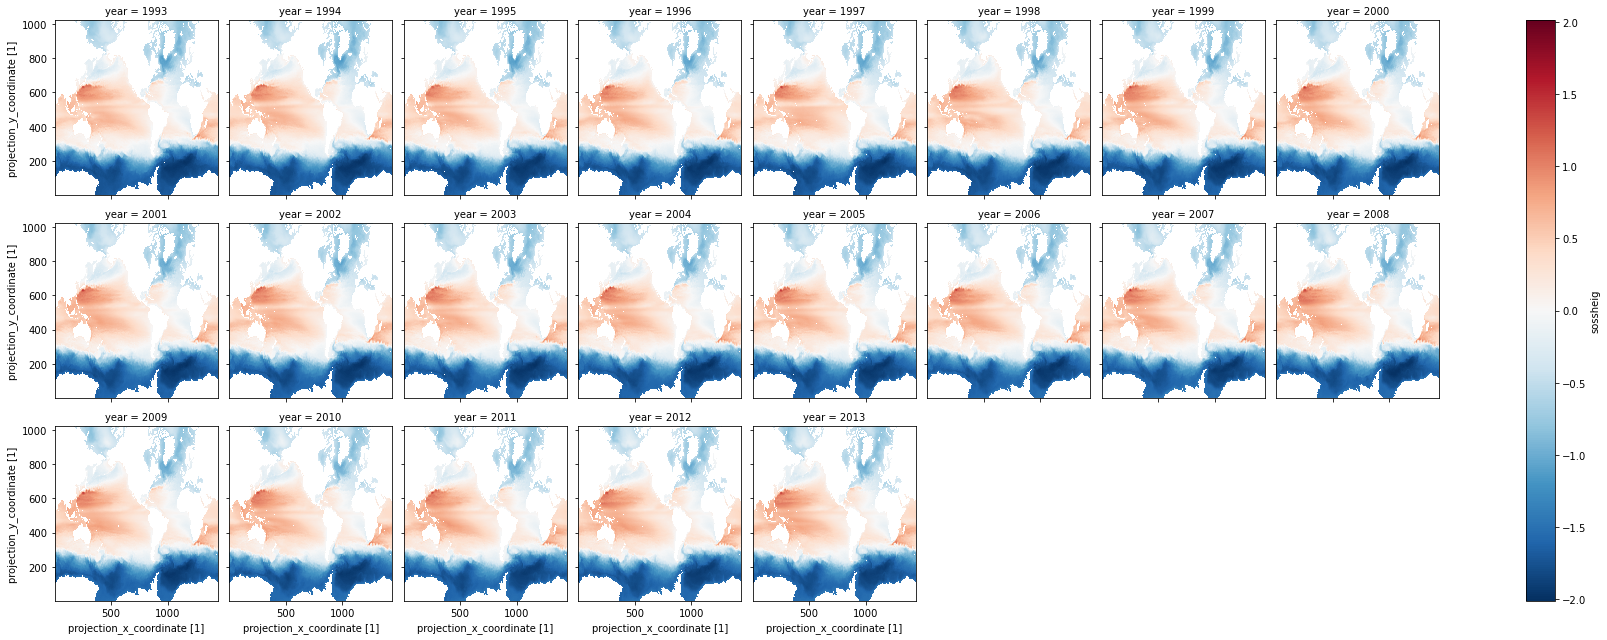

In [17]:
Glorys2v3.sossheig.plot(col = 'year', col_wrap = 8)

In [65]:
# Import ROMS output dewi
roms_output_dewi4_exp29 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/NorthSea4_exp29_zeta.nc')
roms_output_dewi4_exp36 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/NorthSea4_exp36_zeta.nc')
roms_output_dewi8 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/NorthSea8_exp03_zeta.nc')

# Obtain annual averages
roms_output_dewi4_exp29 = roms_output_dewi4_exp29.groupby('ocean_time.year').mean()
roms_output_dewi4_exp36 = roms_output_dewi4_exp36.groupby('ocean_time.year').mean()
roms_output_dewi8 = roms_output_dewi8.groupby('ocean_time.year').mean()

In [66]:
# Obtain anomalies
glorys_anom = glorys12v1.zos.mean('longitude').mean('latitude') - glorys12v1.zos.mean('longitude').mean('latitude').mean('year')

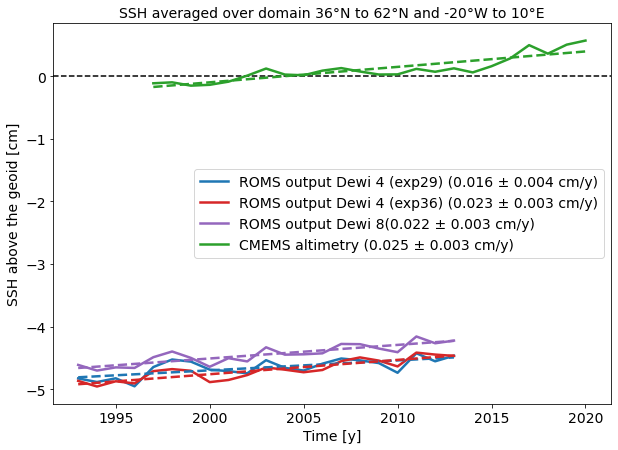

In [77]:
plt.figure(figsize = (10,7))


roms4_exp29_res = linregress(roms_output_dewi4_exp29.year, roms_output_dewi4_exp29.zeta.mean('eta_rho').mean('xi_rho')*10)
roms4_exp29_trend = roms4_exp29_res.slope
roms4_exp29_se = roms4_exp29_res.stderr

roms4_exp36_res = linregress(roms_output_dewi4_exp36.year, roms_output_dewi4_exp36.zeta.mean('eta_rho').mean('xi_rho')*10)
roms4_exp36_trend = roms4_exp36_res.slope
roms4_exp36_se = roms4_exp36_res.stderr

roms8_res = linregress(roms_output_dewi8.year, roms_output_dewi8.zeta.mean('eta_rho').mean('xi_rho')*10)
roms8_trend = roms8_res.slope
roms8_se = roms8_res.stderr

cmems_res = linregress(cmems_altimetry.year, cmems_altimetry.adt.mean('longitude').mean('latitude')*10)
cmems_trend = cmems_res.slope
cmems_se = cmems_res.stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_dewi4_exp29.year, roms_output_dewi4_exp29.zeta.mean('eta_rho').mean('xi_rho')*10, 'tab:blue', 
         linewidth=2.5, label = f'ROMS output Dewi 4 (exp29) ({round(roms4_exp29_trend, 3)} ± {round(roms4_exp29_se, 3)} cm/y)')

plt.plot(roms_output_dewi4_exp36.year, roms_output_dewi4_exp36.zeta.mean('eta_rho').mean('xi_rho')*10, 'tab:red', 
         linewidth=2.5, label = f'ROMS output Dewi 4 (exp36) ({round(roms4_exp36_trend, 3)} ± {round(roms4_exp36_se, 3)} cm/y)')

plt.plot(roms_output_dewi8.year, roms_output_dewi8.zeta.mean('eta_rho').mean('xi_rho')*10, 'tab:purple', 
         linewidth=2.5, label = f'ROMS output Dewi 8({round(roms8_trend, 3)} ± {round(roms8_se, 3)} cm/y)')

plt.plot(cmems_altimetry.year, cmems_altimetry.adt.mean('longitude').mean('latitude')*10, 'tab:green', 
         linewidth=2.5, label = f'CMEMS altimetry ({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_dewi4_exp29.year, roms4_exp29_res.intercept + roms4_exp29_trend*roms_output_dewi4_exp29.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(roms_output_dewi4_exp36.year, roms4_exp36_res.intercept + roms4_exp36_trend*roms_output_dewi4_exp36.year, 'tab:red', linestyle = '--', linewidth = 2.5)
plt.plot(roms_output_dewi8.year, roms8_res.intercept + roms8_trend*roms_output_dewi8.year, 'tab:purple', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_trend*cmems_altimetry.year, 'tab:green', linestyle = '--', linewidth = 2.5)




plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('SSH averaged over domain 36°N to 62°N and -20°W to 10°E', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_area_averaged_ssh_glorys2v3_dewioutput')

In [102]:
# Obtain anomalies
roms4_exp29_anom = roms_output_dewi4_exp29.zeta.mean('eta_rho').mean('xi_rho') - roms_output_dewi4_exp29.where(roms_output_dewi4_exp29.year>=1997, drop = True).zeta.mean('eta_rho').mean('xi_rho').mean('year')
roms4_exp36_anom = roms_output_dewi4_exp36.zeta.mean('eta_rho').mean('xi_rho') - roms_output_dewi4_exp36.where(roms_output_dewi4_exp36.year>=1997, drop = True).zeta.mean('eta_rho').mean('xi_rho').mean('year')
roms8_anom = roms_output_dewi8.zeta.mean('eta_rho').mean('xi_rho') - roms_output_dewi8.where(roms_output_dewi8.year>=1997, drop = True).zeta.mean('eta_rho').mean('xi_rho').mean('year')
cmems_anom = cmems_altimetry.adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude').mean('year')

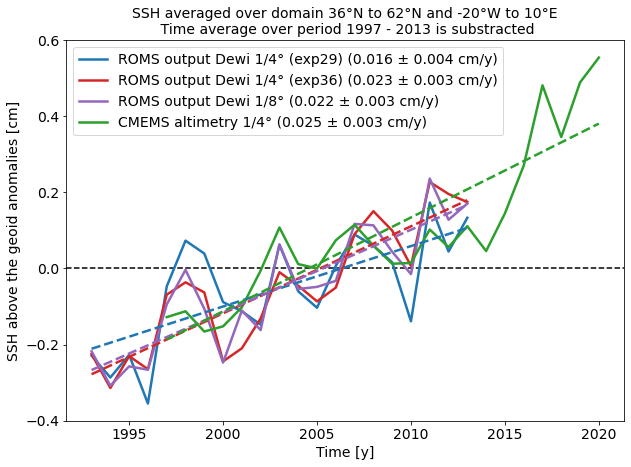

In [103]:
# Plot anomalies

plt.figure(figsize = (10,7))


roms4_exp29_res = linregress(roms4_exp29_anom.year, roms4_exp29_anom*10)
roms4_exp29_trend = roms4_exp29_res.slope
roms4_exp29_se = roms4_exp29_res.stderr

roms4_exp36_res = linregress(roms4_exp36_anom.year, roms4_exp36_anom*10)
roms4_exp36_trend = roms4_exp36_res.slope
roms4_exp36_se = roms4_exp36_res.stderr

roms8_res = linregress(roms8_anom.year, roms8_anom*10)
roms8_trend = roms8_res.slope
roms8_se = roms8_res.stderr

cmems_res = linregress(cmems_anom.year, cmems_anom*10)
cmems_trend = cmems_res.slope
cmems_se = cmems_res.stderr


plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms4_exp29_anom.year, roms4_exp29_anom*10, 'tab:blue', 
         linewidth=2.5, label = f'ROMS output Dewi 1/4° (exp29) ({round(roms4_exp29_trend, 3)} ± {round(roms4_exp29_se, 3)} cm/y)')

plt.plot(roms4_exp36_anom.year, roms4_exp36_anom*10, 'tab:red', 
         linewidth=2.5, label = f'ROMS output Dewi 1/4° (exp36) ({round(roms4_exp36_trend, 3)} ± {round(roms4_exp36_se, 3)} cm/y)')

plt.plot(roms8_anom.year, roms8_anom*10, 'tab:purple', 
         linewidth=2.5, label = f'ROMS output Dewi 1/8° ({round(roms8_trend, 3)} ± {round(roms8_se, 3)} cm/y)')

plt.plot(cmems_anom.year, cmems_anom*10, 'tab:green', 
         linewidth=2.5, label = f'CMEMS altimetry 1/4° ({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_dewi4_exp29.year, roms4_exp29_res.intercept + roms4_exp29_trend*roms4_exp29_anom.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(roms_output_dewi4_exp36.year, roms4_exp36_res.intercept + roms4_exp36_trend*roms4_exp29_anom.year, 'tab:red', linestyle = '--', linewidth = 2.5)
plt.plot(roms_output_dewi8.year, roms8_res.intercept + roms8_trend*roms8_anom.year, 'tab:purple', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_trend*cmems_anom.year, 'tab:green', linestyle = '--', linewidth = 2.5)




plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid anomalies [cm]', fontsize = 14)
plt.title('SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n Time average over period 1997 - 2013 is substracted', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_area_averaged_ssh_glorys2v3_dewioutput_anomalies')

## SSH along the Dutch coast

In [80]:
# Import tide gauge coordinates
tg_coords = pd.read_csv('/Users/iriskeizer/Documents/Wind effect/Data/observations/Coordinates/tgstations.csv', index_col = 'station')

In [81]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the Glorys12v1 data

glorys12v1_stations = pd.DataFrame({'year':glorys12v1.zos.year.values})
glorys12v1_stations = glorys12v1_stations.set_index('year')

for station in tg_coords.index:
    
    glorys12v1_stations[station] = glorys12v1.zos.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
glorys12v1_stations['Average'] = glorys12v1_stations.mean(axis=1)

In [82]:
glorys12v1_stations

,Vlissingen,Hoek v. Holland,Den Helder,Delfzijl,Harlingen,IJmuiden,Average
year,,,,,,,
1993,-0.294656,-0.294300,-0.301930,NaN,-0.283568,-0.289875,-0.292866
1994,-0.249616,-0.250404,-0.254016,NaN,-0.232780,-0.239087,-0.245181
1995,-0.265892,-0.266299,-0.276905,NaN,-0.257780,-0.263756,-0.266126
1996,-0.342850,-0.337433,-0.345851,NaN,-0.339061,-0.338221,-0.340683
1997,-0.279168,-0.273853,-0.280033,NaN,-0.262968,-0.268309,-0.272866
1998,-0.240104,-0.239138,-0.243156,NaN,-0.218691,-0.227312,-0.233680
1999,-0.248980,-0.247988,-0.251829,NaN,-0.226931,-0.236874,-0.242520
2000,-0.236595,-0.236544,-0.239519,NaN,-0.214672,-0.223014,-0.230069
2001,-0.255008,-0.253812,-0.264189,NaN,-0.247836,-0.250633,-0.254295


In [83]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Tim

roms_output_tim_stations = pd.DataFrame({'year':roms_output_tim.slh.year.values})
roms_output_tim_stations = roms_output_tim_stations.set_index('year')

for station in tg_coords.index:
    
    roms_output_tim_stations[station] = roms_output_tim.slh.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
roms_output_tim_stations['Average'] = roms_output_tim_stations.mean(axis=1)

In [84]:
roms_output_tim_stations

,Vlissingen,Hoek v. Holland,Den Helder,Delfzijl,Harlingen,IJmuiden,Average
year,,,,,,,
1993,NaN,NaN,-0.292273,NaN,-0.264440,NaN,-0.278357
1994,NaN,NaN,-0.276727,NaN,-0.243143,NaN,-0.259935
1995,NaN,NaN,-0.296957,NaN,-0.271790,NaN,-0.284374
1996,NaN,NaN,-0.373942,NaN,-0.359973,NaN,-0.366958
1997,NaN,NaN,-0.307426,NaN,-0.280557,NaN,-0.293992
1998,NaN,NaN,-0.264999,NaN,-0.227811,NaN,-0.246405
1999,NaN,NaN,-0.290612,NaN,-0.256689,NaN,-0.273651
2000,NaN,NaN,-0.284223,NaN,-0.247067,NaN,-0.265645
2001,NaN,NaN,-0.293355,NaN,-0.268001,NaN,-0.280678


Currently these dataframes also contain nan values which could be improved but is not necessary

In [85]:
cmems_altimetry

<xarray.Dataset>
Dimensions:    (year: 24, latitude: 208, longitude: 241)
Coordinates:
  * latitude   (latitude) float32 36.06 36.19 36.31 36.44 ... 61.69 61.81 61.94
  * longitude  (longitude) float32 -20.06 -19.94 -19.81 ... 9.688 9.812 9.938
  * year       (year) int64 1997 1998 1999 2000 2001 ... 2017 2018 2019 2020
Data variables:
    adt        (year, latitude, longitude) float64 dask.array<chunksize=(1, 208, 241), meta=np.ndarray>
    crs        (year) float64 -2.147e+09 -2.147e+09 ... -2.147e+09 -2.147e+09

In [86]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Tim

cmems_altimetry_stations = pd.DataFrame({'year':cmems_altimetry.year.values})
cmems_altimetry_stations = cmems_altimetry_stations.set_index('year')

for station in tg_coords.index:
    
    cmems_altimetry_stations[station] = cmems_altimetry.adt.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
cmems_altimetry_stations['Average'] = cmems_altimetry_stations.mean(axis=1)

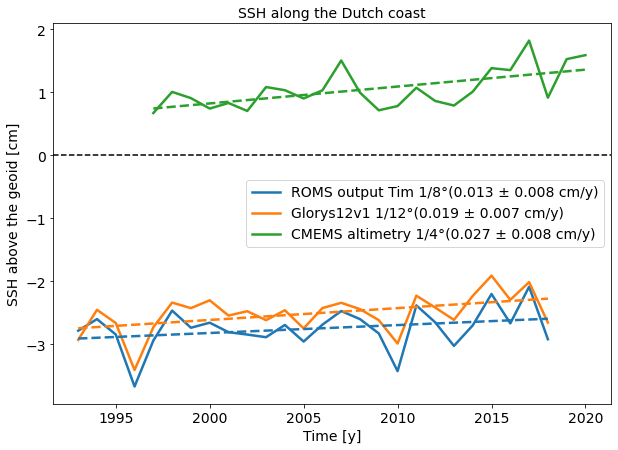

In [97]:
plt.figure(figsize = (10,7))

glorys_res = linregress(glorys12v1_stations.index, glorys12v1_stations['Average']*10)
glorys_trend = glorys_res.slope
glorys_se = glorys_res.stderr

roms_res = linregress(roms_output_tim_stations.index, roms_output_tim_stations['Average']*10)
roms_trend = roms_res.slope
roms_se = roms_res.stderr

cmems_res = linregress(cmems_altimetry_stations.index, cmems_altimetry_stations['Average']*10)
cmems_trend = cmems_res.slope
cmems_se = cmems_res.stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_tim_stations.index, roms_output_tim_stations['Average']*10, linewidth=2.5, label = f'ROMS output Tim 1/8°({round(roms_trend, 3)} ± {round(roms_se, 3)} cm/y)')
plt.plot(glorys12v1_stations.index, glorys12v1_stations['Average']*10, linewidth=2.5, label = f'Glorys12v1 1/12°({round(glorys_trend, 3)} ± {round(glorys_se, 3)} cm/y)')
plt.plot(cmems_altimetry_stations.index, cmems_altimetry_stations['Average']*10, linewidth=2.5, label = f'CMEMS altimetry 1/4°({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_tim_stations.index, roms_res.intercept + roms_res.slope*roms_output_tim_stations.index, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(glorys12v1.year, glorys_res.intercept + glorys_res.slope*glorys12v1_stations.index, 'tab:orange', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry_stations.index, cmems_res.intercept + cmems_res.slope*cmems_altimetry_stations.index, 'tab:green', linestyle = '--', linewidth = 2.5)



plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('SSH along the Dutch coast', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_area_averaged_ssh_glorys12_timoutput8')

In [98]:
# Obtain anomalies by substracting the mean of overlap period
glorys_stat_anom = glorys12v1_stations['Average'] - glorys12v1_stations[4:]['Average'].mean()
roms_tim_stat_anom = roms_output_tim_stations['Average'] - roms_output_tim_stations[4:]['Average'].mean()
cmems_stat_anom = cmems_altimetry_stations['Average'] - cmems_altimetry_stations[:-2]['Average'].mean()

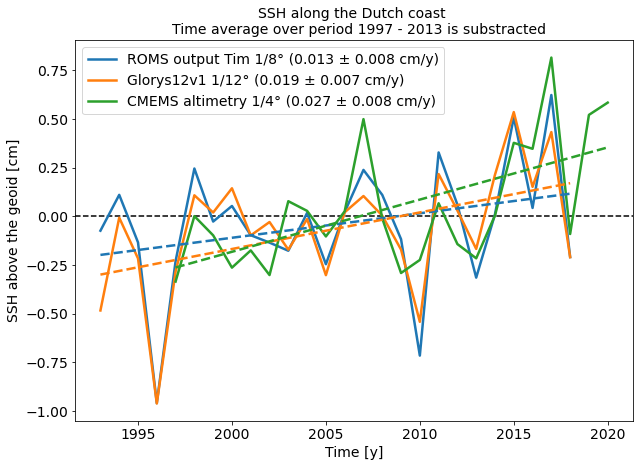

In [104]:
plt.figure(figsize = (10,7))


glorys_res = linregress(glorys12v1.year, glorys_stat_anom*10)
glorys_trend = glorys_res.slope
glorys_se = glorys_res.stderr

roms_res = linregress(roms_output_tim.year, roms_tim_stat_anom*10)
roms_trend = roms_res.slope
roms_se = roms_res.stderr

cmems_res = linregress(cmems_altimetry.year, cmems_stat_anom*10)
cmems_trend = cmems_res.slope
cmems_se = cmems_res.stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_tim.year, roms_tim_stat_anom*10, linewidth=2.5, label = f'ROMS output Tim 1/8° ({round(roms_trend, 3)} ± {round(roms_se, 3)} cm/y)')
plt.plot(glorys12v1.year, glorys_stat_anom*10, linewidth=2.5, label = f'Glorys12v1 1/12° ({round(glorys_trend, 3)} ± {round(glorys_se, 3)} cm/y)')
plt.plot(cmems_altimetry.year, cmems_stat_anom*10, linewidth=2.5, label = f'CMEMS altimetry 1/4° ({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_tim.year, roms_res.intercept + roms_res.slope*roms_output_tim.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(glorys12v1.year, glorys_res.intercept + glorys_res.slope*glorys12v1.year, 'tab:orange', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_res.slope*cmems_altimetry.year, 'tab:green', linestyle = '--', linewidth = 2.5)



plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('SSH along the Dutch coast \n  Time average over period 1997 - 2013 is substracted', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_area_averaged_ssh_glorys12_timoutput8_anomalies')

#### Difference between ROMS averaged sea level and sea level along the Dutch coast

In [92]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

glorys12v1_difference = glorys12v1.zos.mean('longitude').mean('latitude').values - glorys12v1_stations['Average'].values
roms_output_tim_difference = roms_output_tim.slh.mean('lat').mean('lon').values - roms_output_tim_stations['Average'].values
cmems_altimetry_difference = cmems_altimetry.adt.mean('longitude').mean('latitude').values - cmems_altimetry_stations['Average'].values

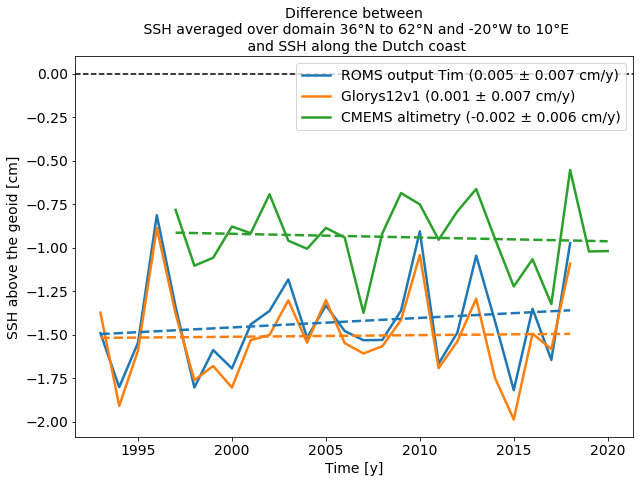

In [106]:
plt.figure(figsize = (10,7))


glorys_res = linregress(glorys12v1.year, glorys12v1_difference*10)
glorys_trend = glorys_res.slope
glorys_se = glorys_res.stderr

roms_res = linregress(roms_output_tim.year, roms_output_tim_difference*10)
roms_trend = roms_res.slope
roms_se = roms_res.stderr

cmems_res = linregress(cmems_altimetry.year, cmems_altimetry_difference*10)
cmems_trend = cmems_res.slope
cmems_se = cmems_res.stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_tim.year, roms_output_tim_difference*10, linewidth=2.5, label = f'ROMS output Tim ({round(roms_trend, 3)} ± {round(roms_se, 3)} cm/y)')
plt.plot(glorys12v1.year, glorys12v1_difference*10, linewidth=2.5, label = f'Glorys12v1 ({round(glorys_trend, 3)} ± {round(glorys_se, 3)} cm/y)')
plt.plot(cmems_altimetry.year, cmems_altimetry_difference*10, linewidth=2.5, label = f'CMEMS altimetry ({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_tim.year, roms_res.intercept + roms_res.slope*roms_output_tim.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(glorys12v1.year, glorys_res.intercept + glorys_res.slope*glorys12v1.year, 'tab:orange', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_res.slope*cmems_altimetry.year, 'tab:green', linestyle = '--', linewidth = 2.5)



plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('Difference between\n SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH along the Dutch coast', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_difference_ssh_glorys12_timoutput8')





#### Differences for anomalies

In [94]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

glorys_difference_anom = glorys_anom - glorys_stat_anom
roms_tim_difference_anom = roms_tim_anom - roms_tim_stat_anom
cmems_difference_anom = cmems_anom - cmems_stat_anom

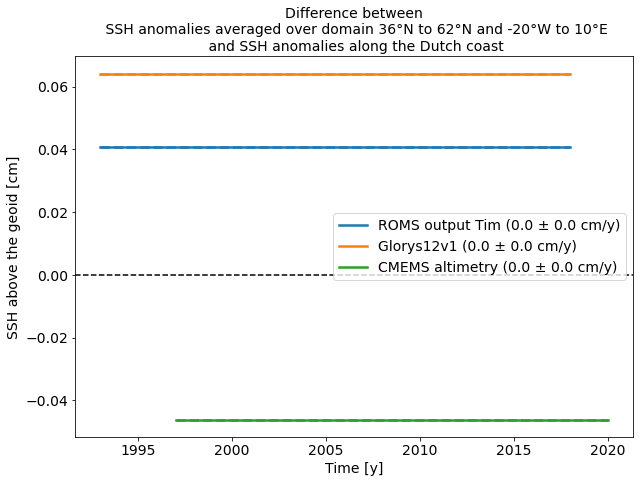

In [107]:
plt.figure(figsize = (10,7))


glorys_res = linregress(glorys12v1.year, glorys_difference_anom*10)
glorys_trend = glorys_res.slope
glorys_se = glorys_res.stderr

roms_res = linregress(roms_output_tim.year, roms_tim_difference_anom*10)
roms_trend = roms_res.slope
roms_se = roms_res.stderr

cmems_res = linregress(cmems_altimetry.year, cmems_difference_anom*10)
cmems_trend = cmems_res.slope
cmems_se = cmems_res.stderr

plt.axhline(color='k', linestyle='--', linewidth = 1.5)

plt.plot(roms_output_tim.year, roms_tim_difference_anom*10, linewidth=2.5, label = f'ROMS output Tim ({round(roms_trend, 3)} ± {round(roms_se, 3)} cm/y)')
plt.plot(glorys12v1.year, glorys_difference_anom*10, linewidth=2.5, label = f'Glorys12v1 ({round(glorys_trend, 3)} ± {round(glorys_se, 3)} cm/y)')
plt.plot(cmems_altimetry.year, cmems_difference_anom*10, linewidth=2.5, label = f'CMEMS altimetry ({round(cmems_trend, 3)} ± {round(cmems_se, 3)} cm/y)')


plt.plot(roms_output_tim.year, roms_res.intercept + roms_res.slope*roms_output_tim.year, 'tab:blue', linestyle = '--', linewidth = 2.5)
plt.plot(glorys12v1.year, glorys_res.intercept + glorys_res.slope*glorys12v1.year, 'tab:orange', linestyle = '--', linewidth = 2.5)
plt.plot(cmems_altimetry.year, cmems_res.intercept + cmems_res.slope*cmems_altimetry.year, 'tab:green', linestyle = '--', linewidth = 2.5)



plt.xlabel('Time [y]', fontsize =  14)
plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
plt.title('Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast', fontsize = 14)

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/glorys_vs_roms/tim output/roms_difference_ssh_glorys12_timoutput8')



